In [1]:
import pandas as pd
import numpy as np
import datetime
from filegenerators import *
pd.options.display.float_format = '{:.2e}'.format
from pathlib import Path
from CovCor_calc import OptimaMechtest, OptimaOutput, OptimaSensitivity
import seaborn as sns
import matplotlib.pyplot as plt
import os
import copy
pd.set_option('display.float_format', '{:.6e}'.format)

In [2]:
"""
If ic=0 => absolute sigma => dataPoint variablestd = small error
If ic!=0 rel sigma => common properties => new property value = ln((val/1.5)/(val*1.5))/4
"""
def splitSigmas(df, inputs, observables, must_be_zero, wide=False):
    rel_sigmas = dict()
    abs_sigmas = dict()

    for index, row in df.iterrows():
        if row.species in inputs:
#        if row.species not in observables:
            continue
        if row.value in must_be_zero and row.species not in inputs:
            rel_sigmas[row.species] = 5e-14
        elif row.species not in inputs and row.species in observables:
            if wide:
                rel_sigmas[row.species] = ((row.maxconc-row.minconc)/8)*1e-12
            else:
                rel_sigmas[row.species] = ((row.value*1.5-row.value/2)/8)*1e-12
    return rel_sigmas

In [3]:
df_species_ics = pd.read_excel('input_files/reactions_ics_finalised.xlsx', sheet_name='icranges')
df_species_ics['value'] = df_species_ics['value'].astype(float)

observables = []
for index, row in df_species_ics.iterrows():
    if row.value > 0:
        observables.append(row.species)
with open ('observables.txt', 'w') as f:
    for spec in observables:
        f.write(f"{spec}\n")
len(observables)

35

In [4]:
#inoputokat ki kell szedni
input_names =  ['nS', 'RAP', 'TG', 'dS', 'CCH', 'REF', 'Insulin', 'TG_SERCA', 'mTOR_RAP', 'casp', 'IP3R', 'Baxa', 'tBid']
must_be_zero = ['casp', 'Baxa', 'tBid', 'p53a', 'PUMA']
inputs = {}
for i in input_names:
    inputs[i] = 0.0
inputs["REF"] = 1.0
inputs["Insulin"] = 1e-10

In [5]:
input_data = pd.DataFrame([
    {'species': species, 'minconc': value, 'value': value, 'maxconc': value}
    for species, value in inputs.items()
])

In [6]:
lut = pd.concat([df_species_ics, input_data], ignore_index=True)    # look-up-table
lut['species'] = lut['species'].str.upper()
lut.shape

(84, 4)

In [7]:
naro_sigmas = splitSigmas(df=df_species_ics, inputs=inputs, observables=observables, must_be_zero=must_be_zero)
wide_sigmas = splitSigmas(df=df_species_ics, inputs=inputs, observables=observables, must_be_zero=must_be_zero, wide=True)
len(naro_sigmas)

34

In [8]:
old_ones: dict[str, OptimaMechtest] = {}
indices = ['1000', '2000', '3000', '4000']#, '5000']
for idx in indices:
    old_ones[idx] = OptimaMechtest(f"2025526_BCRN_corr_{idx}_old.opp")

In [117]:
# calculates the distance between the measurements and normalise them with the appropriate sigma value
def sigma_range(meas, sim, sigma):
    radius = (sim-meas)/sigma
    return radius

In [118]:
def isit_init(row, wide=False):
    for k, v in row.items():
        right_row = lut[lut['species'] == k]

        if right_row.empty or k not in naro_sigmas.keys():
            #print(f"Species '{species}' not found in lut — skipping.")
            continue    # ezekre: BEC1A, PI3K, PI3KA, SERCAA nincsen adat a ranges tablazatban

        meas = right_row['value'].iloc[0] * 1e-12

        if not wide:
            radius = sigma_range(meas=meas, sim=v*1e-12, sigma=naro_sigmas[k])
        else:
            radius = sigma_range(meas=meas, sim=v*1e-12, sigma=wide_sigmas[k])
        #print(radius)
        if radius >= 4:
            return False

    return True


In [119]:
all_ok = True
old_good_xmls = []
new_good_xmls = []

for idx in indices:
    for xml_name, row in old_ones[idx].df_followed34.iterrows():
        all_ok = isit_init(row)
        if all_ok:
            old_good_xmls.append(xml_name)

for xml_name, row in new_result.df_followed34.iterrows():
    all_ok = isit_init(row)
    if all_ok:
        new_good_xmls.append(xml_name)

len(old_good_xmls)#, len(new_good_xmls)

4759

In [121]:
data = copy.deepcopy(old_ones)      # fckn python does all assignments with shitty references, duuuuhh

In [122]:
old_ones['1000'].df_basal

,x_AC,x_AC_GA,x_AC_GAA,x_AKT,x_AKTA,x_AMPK,x_AMPKA,x_ATG5,x_ATG5T,x_ATG5_BCL2,...,x_SERCA,x_SERCAA,x_TBID,x_TG,x_TG_SERCA,x_TSC,x_TSCA,x_ULK,x_ULKA,x_UVG
states_stac_0409_p1_BCRN6,2.272489e+02,9.100901e-02,7.259564e-05,1.901650e+01,3.432316e+01,2.219426e+02,8.971540e+01,1.913595e+02,1.351327e+00,2.070787e+01,...,8.591475e+01,0.000000e+00,4.892532e-01,0.000000e+00,0.000000e+00,3.161795e+02,2.306180e-03,9.191058e+01,1.039572e+01,5.850115e+01
states_stac_0630_p1_BCRN6,2.564097e+02,3.454951e-02,7.912633e-05,3.995123e+01,7.254109e+01,1.320018e+02,6.607473e+01,1.913297e+02,1.119538e+00,2.992202e+01,...,1.410625e+02,0.000000e+00,4.976033e-01,0.000000e+00,0.000000e+00,2.924747e+02,7.433983e-04,9.426653e+01,9.347782e+00,8.441398e+01
states_stac_0014_p1_BCRN6,1.125285e+02,5.274152e-02,2.638681e-05,4.919629e+01,8.792367e+01,1.246840e+02,1.202711e+02,1.912962e+02,2.475423e+00,3.577080e+01,...,9.521373e+01,0.000000e+00,4.892682e-01,0.000000e+00,0.000000e+00,2.780101e+02,1.061203e-03,6.299993e+01,9.769006e+00,1.207431e+02
states_stac_0895_p1_BCRN6,2.938086e+02,5.661594e-02,7.568112e-05,2.448760e+01,4.411086e+01,3.717238e+02,1.794328e+02,1.913665e+02,2.712350e+00,3.020949e+01,...,5.787764e+01,0.000000e+00,4.893083e-01,0.000000e+00,0.000000e+00,3.122684e+02,3.544585e-03,5.837878e+01,8.916186e+00,1.370085e+02
states_stac_0296_p1_BCRN6,1.770061e+02,9.108628e-02,4.825206e-05,5.199223e+01,8.964908e+01,1.774791e+02,1.864225e+02,1.911953e+02,1.461478e+00,2.322187e+01,...,1.489742e+02,0.000000e+00,4.892499e-01,0.000000e+00,0.000000e+00,2.318926e+02,1.345617e-03,3.247974e+01,4.000493e+00,1.034880e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
states_stac_0531_p1_BCRN6,2.877999e+02,7.086439e-02,5.092653e-05,5.247502e+01,9.253239e+01,2.131078e+02,1.741444e+02,1.913065e+02,1.253174e+00,2.093223e+01,...,7.731259e+01,0.000000e+00,4.893499e-01,0.000000e+00,0.000000e+00,1.408689e+02,7.397977e-04,6.397091e+01,1.115327e+01,1.148717e+02
states_stac_0163_p1_BCRN6,1.705527e+02,2.918355e-02,6.771653e-05,3.409830e+01,6.081441e+01,1.309914e+02,6.612036e+01,1.913630e+02,1.411202e+00,3.240529e+01,...,8.460989e+01,0.000000e+00,4.892618e-01,0.000000e+00,0.000000e+00,1.268333e+02,3.848076e-04,8.019916e+01,1.438186e+01,1.162613e+02
states_stac_0057_p1_BCRN6,1.040030e+02,1.946326e-02,4.114813e-05,3.373558e+01,5.741915e+01,3.106249e+02,2.286882e+02,1.913029e+02,6.219940e-01,1.820573e+01,...,5.837202e+01,0.000000e+00,4.892884e-01,0.000000e+00,0.000000e+00,2.629576e+02,2.922478e-03,5.898056e+01,5.525981e+00,1.155006e+02
states_stac_0879_p1_BCRN6,1.123578e+02,8.981672e-02,1.697352e-05,2.077280e+01,3.766604e+01,1.654832e+02,1.514456e+02,1.913292e+02,2.890167e+00,3.167948e+01,...,6.983348e+01,0.000000e+00,4.892924e-01,0.000000e+00,0.000000e+00,2.426131e+02,2.722090e-03,3.183238e+01,4.072818e+00,6.957611e+01


In [123]:
# Filtering
first = True
for k, v in data.items():
    v.df_basal.index = v.df_basal.index.str[7:16]
    v.df_basal = v.df_basal.sort_index()
    if first:
        filtered_basal = v.df_basal[[xml in old_good_xmls for xml in v.df_basal.index]]
        filtered_followed = v.df_followed34[[xml in old_good_xmls for xml in v.df_followed34.index]]
        first = False
    else:
        filtered_basal = pd.concat([filtered_basal, v.df_basal[[xml in old_good_xmls for xml in v.df_basal.index]]],
                                   ignore_index=False)
        filtered_followed = pd.concat([filtered_followed, v.df_followed34[[xml in old_good_xmls for xml in v.df_followed34.index]]],
                                      ignore_index=False)

In [125]:
filtered_basal

,x_AC,x_AC_GA,x_AC_GAA,x_AKT,x_AKTA,x_AMPK,x_AMPKA,x_ATG5,x_ATG5T,x_ATG5_BCL2,...,x_SERCA,x_SERCAA,x_TBID,x_TG,x_TG_SERCA,x_TSC,x_TSCA,x_ULK,x_ULKA,x_UVG
stac_0001,2.066787e+02,7.230904e-02,2.367115e-05,1.833074e+01,3.177691e+01,3.077261e+02,8.082397e+01,1.912916e+02,1.325419e+00,1.944032e+01,...,5.182883e+01,0.000000e+00,4.891662e-01,0.000000e+00,0.000000e+00,1.773205e+02,1.258542e-03,4.289094e+01,6.492506e+00,7.982880e+01
stac_0002,1.966509e+02,1.868778e-02,7.895030e-05,3.758714e+01,6.744675e+01,2.158427e+02,1.682039e+02,1.912392e+02,1.389190e+00,2.499929e+01,...,6.622986e+01,0.000000e+00,4.892886e-01,0.000000e+00,0.000000e+00,2.330648e+02,1.621935e-03,3.920366e+01,5.298372e+00,8.629986e+01
stac_0003,2.691648e+02,2.411810e-02,3.544039e-05,2.878264e+01,5.039909e+01,1.922867e+02,1.622017e+02,1.912915e+02,2.016255e+00,2.529185e+01,...,8.615648e+01,0.000000e+00,4.892588e-01,0.000000e+00,0.000000e+00,1.750874e+02,1.572422e-03,7.081165e+01,9.697241e+00,5.683327e+01
stac_0004,1.216714e+02,8.796604e-02,2.010759e-05,5.252149e+01,9.480390e+01,3.502620e+02,1.601440e+02,1.911913e+02,1.614049e+00,3.743223e+01,...,9.014954e+01,0.000000e+00,4.896065e-01,0.000000e+00,0.000000e+00,2.373398e+02,1.118761e-03,7.914931e+01,1.631748e+01,1.007093e+02
stac_0005,2.559395e+02,3.282294e-02,8.673196e-05,2.551373e+01,4.523118e+01,8.580499e+01,1.370605e+02,1.911952e+02,1.303948e+00,2.516604e+01,...,1.139795e+02,0.000000e+00,4.886611e-01,0.000000e+00,0.000000e+00,2.955994e+02,2.492586e-03,5.928124e+01,6.620555e+00,1.056556e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stac_4995,1.893324e+02,5.300006e-02,3.408547e-05,3.711272e+01,6.514544e+01,2.624301e+02,2.533149e+02,1.912749e+02,1.471487e+00,3.916409e+01,...,6.714736e+01,0.000000e+00,4.892517e-01,0.000000e+00,0.000000e+00,3.234994e+02,3.510198e-03,4.964114e+01,7.168862e+00,1.391261e+02
stac_4996,1.622898e+02,8.425541e-02,2.241197e-05,2.863648e+01,5.152124e+01,2.413836e+02,1.377005e+02,1.912185e+02,2.067114e+00,3.184159e+01,...,6.385205e+01,0.000000e+00,4.892521e-01,0.000000e+00,0.000000e+00,3.260612e+02,2.431811e-03,8.077514e+01,1.407945e+01,7.754006e+01
stac_4997,1.770525e+02,1.589718e-02,4.258387e-05,4.044931e+01,7.289929e+01,1.505367e+02,2.281952e+02,1.912916e+02,1.720477e+00,4.047161e+01,...,9.184085e+01,0.000000e+00,4.892881e-01,0.000000e+00,0.000000e+00,3.017257e+02,2.635592e-03,4.359254e+01,4.240617e+00,9.789032e+01
stac_4998,1.410488e+02,8.008933e-02,2.312274e-05,3.566492e+01,6.256314e+01,8.250620e+01,1.998892e+02,1.911824e+02,2.809985e+00,2.091840e+01,...,1.127925e+02,0.000000e+00,4.892764e-01,0.000000e+00,0.000000e+00,2.880501e+02,2.568159e-03,5.121065e+01,4.154122e+00,8.676279e+01


In [126]:
corr_xmls = [50]
dict_old_f = {}   # Ebbe lesznek az adott sorszamu dataframe-ek
dict_old_b = {}
dict_new_f = {}   # for df_followed34
dict_new_b = {}   # for df_basal
dict_old_f_corr = {}
dict_old_b_corr = {}
dict_new_f_corr = {}
dict_new_b_corr = {}

In [127]:
corr_xmls = [np.arange(0, 50, 1), np.arange(50, 200, 1), np.arange(200, 500, 1),
             np.arange(500, 1000, 1), np.arange(1000, 2000, 1), np.arange(2000, len(old_good_xmls), 1)]
keys = ['50', '150', '300', '500', '1000', f"{len(old_good_xmls) - 2000}"]

for idx, range in enumerate(corr_xmls):
    dict_old_f[f"{keys[idx]}"] = filtered_followed.iloc[range].copy()
    dict_old_b[f"{keys[idx]}"] = filtered_basal.iloc[range].copy()
    dict_old_f_corr[f"{keys[idx]}"] = filtered_followed.iloc[range].copy().corr()
    dict_old_b_corr[f"{keys[idx]}"] = filtered_basal.iloc[range].copy().corr()

In [130]:
def plot_corr_matrix(df_corr, title="", figsize=(12, 10), vmin=-1, vmax=1, fontsize=7, dropNa = False):
    
    if dropNa:
        df_corr = df_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

    plt.figure(figsize=figsize)
    sns.heatmap(df_corr, 
                annot=False, 
                cmap='coolwarm', 
                center=0,
                vmin=vmin,
                vmax=vmax,
                xticklabels=True,
                yticklabels=True,
                square=True,
                linewidths=0.3,
                cbar_kws={"shrink": 0.8})
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title}.pdf")
    plt.show()

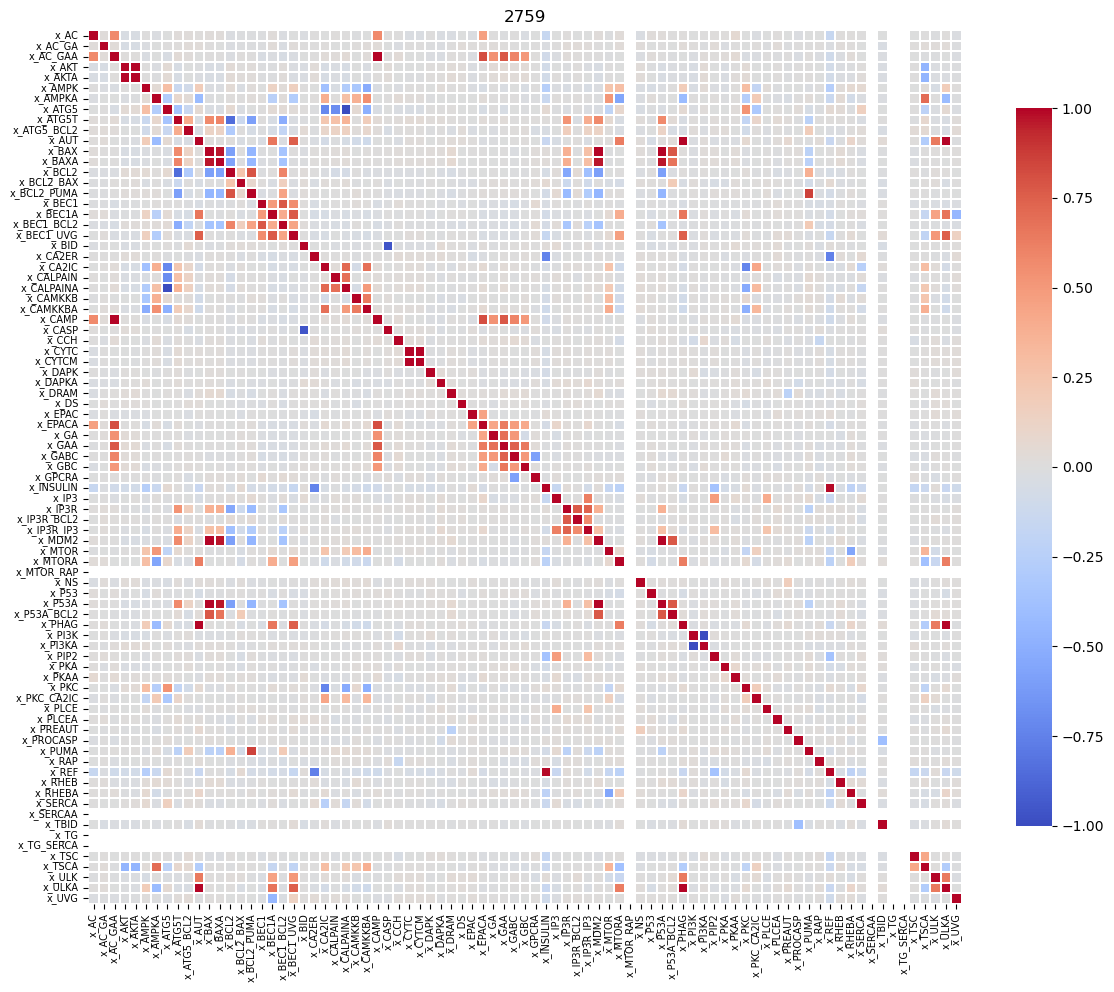

In [131]:
plot_corr_matrix(dict_old_b_corr['2759'], title='2759')#, dropNa=True)

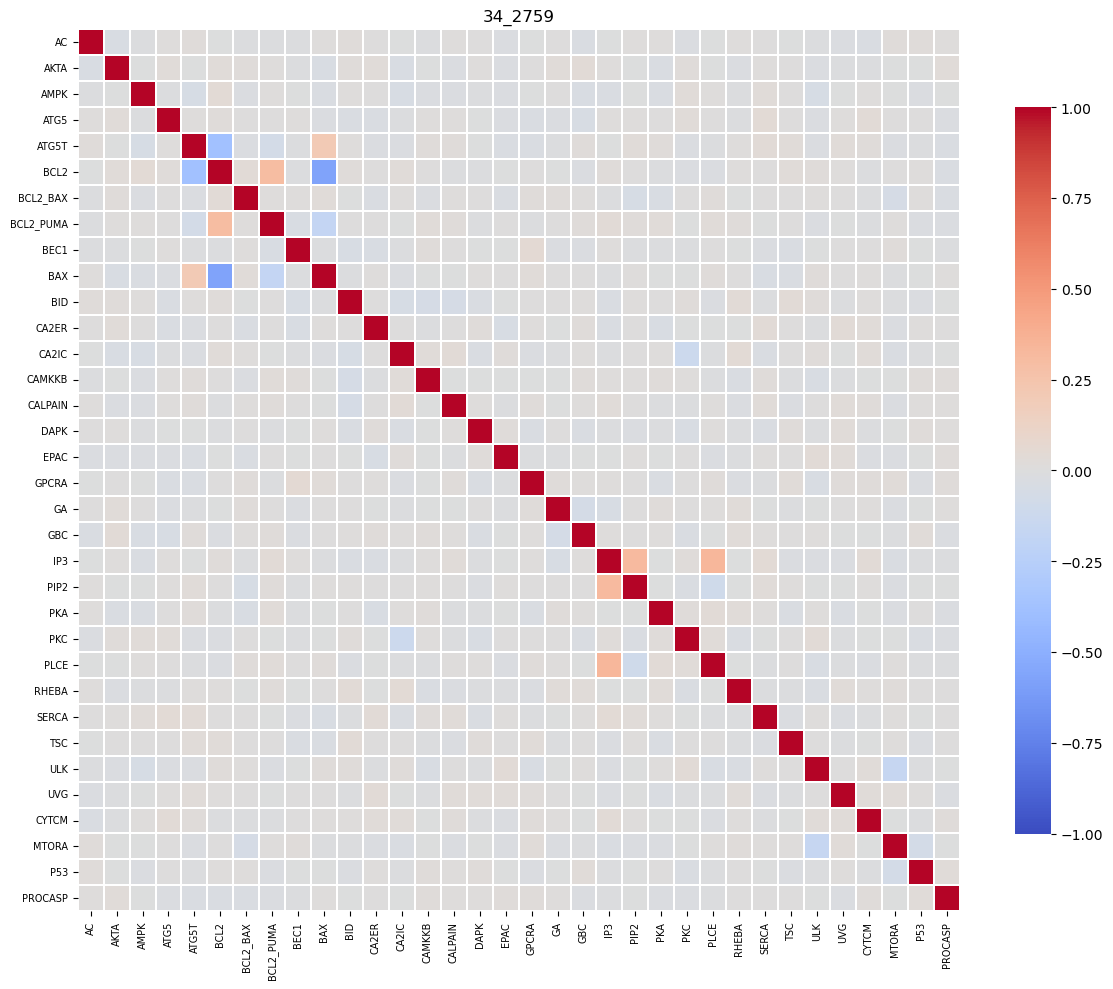

In [132]:
plot_corr_matrix(dict_old_f_corr['2759'], title='34_2759')

In [133]:
def correlation_matrix_distance(A, B):
    """Correlation Matrix Distance (CMD), Herdin et al. (2005), https://doi.org/10.1049/el:20057319"""
    numerator = np.trace(A @ B)
    denominator = np.linalg.norm(A, 'fro') * np.linalg.norm(B, 'fro')
    return 1 - (numerator / denominator)

def rv_coefficient(A, B):
    """RV Coefficient, Escoufier (1973), https://doi.org/10.1016/0378-3758(78)90121-8"""
    numerator = np.trace(A @ B)
    denominator = np.sqrt(np.trace(A @ A) * np.trace(B @ B))
    return numerator / denominator

In [134]:
def compute_matrix_distance(mat1, mat2, method='fro'):
    if method == 'frobenius':
        return np.linalg.norm(mat1 - mat2, ord='fro')
    elif method == 'cmd':
        return correlation_matrix_distance(mat1, mat2)
    elif method == 'rv':
        return rv_coefficient(mat1, mat2)
    else:
        raise ValueError("Unknown method. Use 'frobenius', 'cmd', or 'rv'.")

In [136]:
def plot_correlation_distance_heatmap(corr_dict, corr_xmls, method='frobenius'):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = corr_dict[str(n1)].values
            mat2 = corr_dict[str(n2)].values
            distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)

    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_matrix,
                xticklabels=corr_xmls,
                yticklabels=corr_xmls,
                annot=True,
                cmap='coolwarm',
                square=True,
                cbar_kws={'label': f'{method.capitalize()} Distance'})
    plt.title(f'{method.capitalize()} Distance Between Correlation Matrices')
    plt.xlabel('Number of XMLs')
    plt.ylabel('Number of XMLs')
    plt.tight_layout()
    plt.show()

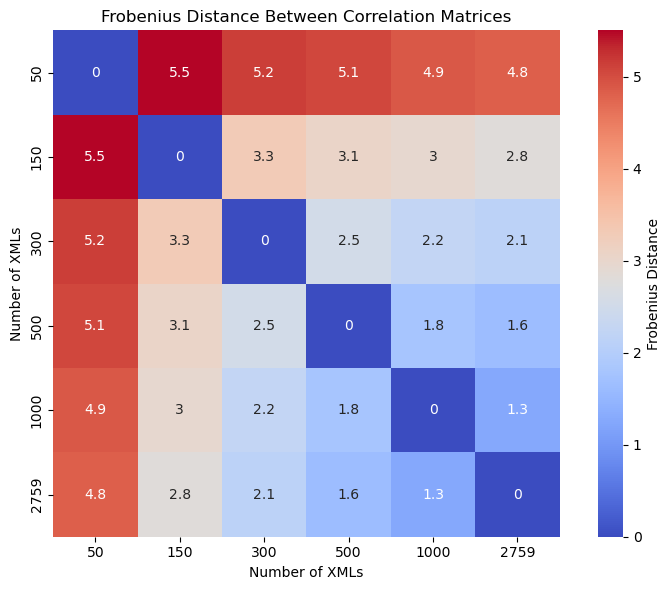

In [137]:
plot_correlation_distance_heatmap(corr_dict=dict_old_f_corr, corr_xmls=keys)

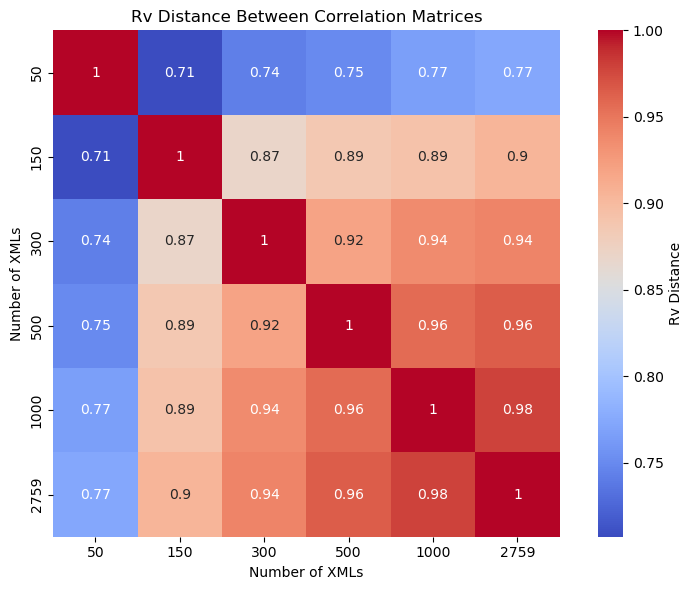

'\nRV metric:\n    - Bounded between 0 and 1\n    - 1 indicates identical structure (up to scale)\n'

In [139]:
plot_correlation_distance_heatmap(corr_dict=dict_old_f_corr, corr_xmls=keys, method='rv')
"""
RV metric:
    - Bounded between 0 and 1
    - 1 indicates identical structure (up to scale)
"""

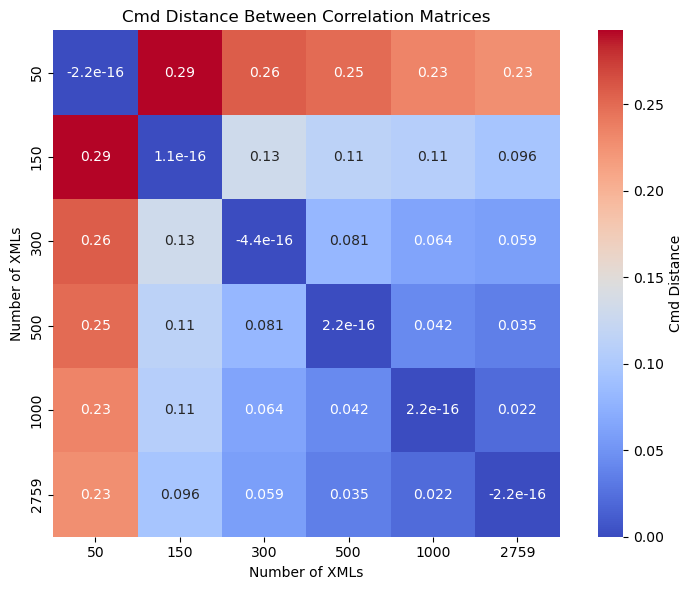

'\nCMD metric:\n    - Normalized: 0 if matrices are identical, 1 if they are orthogonal\n'

In [141]:
plot_correlation_distance_heatmap(corr_dict=dict_old_f_corr, corr_xmls=keys, method='cmd')
"""
CMD metric:
    - Normalized: 0 if matrices are identical, 1 if they are orthogonal
"""

In [ ]:
num_corrs = len(corr_xmls)
distance_matrix = np.zeros((num_corrs, num_corrs))
# Compute pairwise Frobenius norm between correlation matrices
for i, n1 in enumerate(corr_xmls):
    for j, n2 in enumerate(corr_xmls):
        mat1 = dict_old_f_corr[str(n1)]
        mat2 = dict_old_f_corr[str(n2)]
        diff = mat1 - mat2
        norm = compute_matrix_distance(mat1, mat2)
        distance_matrix[i, j] = norm

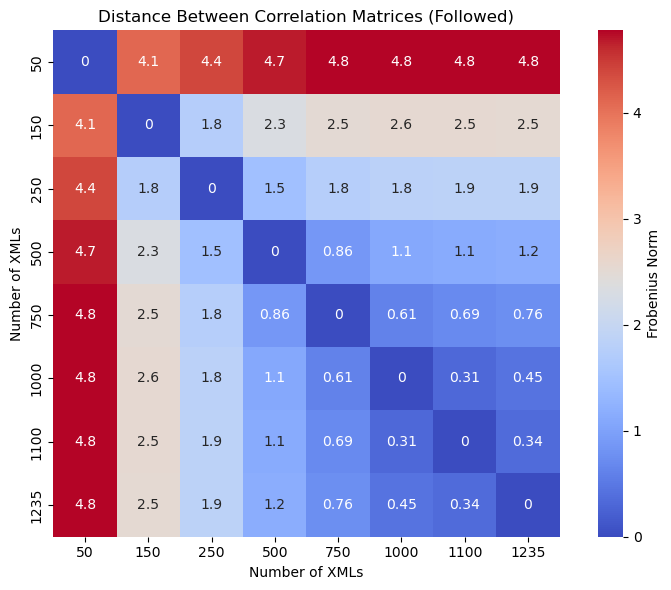

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix, 
            xticklabels=corr_xmls, 
            yticklabels=corr_xmls, 
            annot=True, 
            cmap='coolwarm', 
            square=True, 
            cbar_kws={'label': 'Frobenius Norm'})
plt.title('Distance Between Correlation Matrices (Followed)')
plt.xlabel('Number of XMLs')
plt.ylabel('Number of XMLs')
plt.tight_layout()
plt.show()

In [1]:
for i in range(5, 15+1):
    print(i)

5
6
7
8
9
10
11
12
13
14
15
